# Convert word to vector with spaCy

In [1]:
# Load spaCy model
import spacy
nlp = spacy.load('en_core_web_lg')

In [2]:
# Load nouns that appear at least 1000 times
input_file = 'data/nouns_1000.txt'

nouns = []
with open(input_file, 'r') as f:
    for line in f:
        nouns.append(line[:-1])  # Remove newline
print(len(nouns))

1350


In [3]:
# Use spaCy model to get tokens
# Remove docs that have more than one token
def get_tokens(nouns):
    docs = [nlp(noun) for noun in nouns]
    tokens = [doc[0] for doc in docs if len(doc) == 1]
    return tokens

In [4]:
tokens = get_tokens(nouns)
print(len(tokens))

1350


In [5]:
# Get nouns that are in the vocabulary of the model
inv_nouns = [token for token in tokens if not token.is_oov]
print(len(inv_nouns))

1347


In [6]:
# Get vectors
vectors = [noun.vector for noun in inv_nouns]

# View words

In [7]:
vectors_20 = vectors[:20]

In [8]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(vectors_20)
vectors_20_2D = pca.transform(vectors_20)

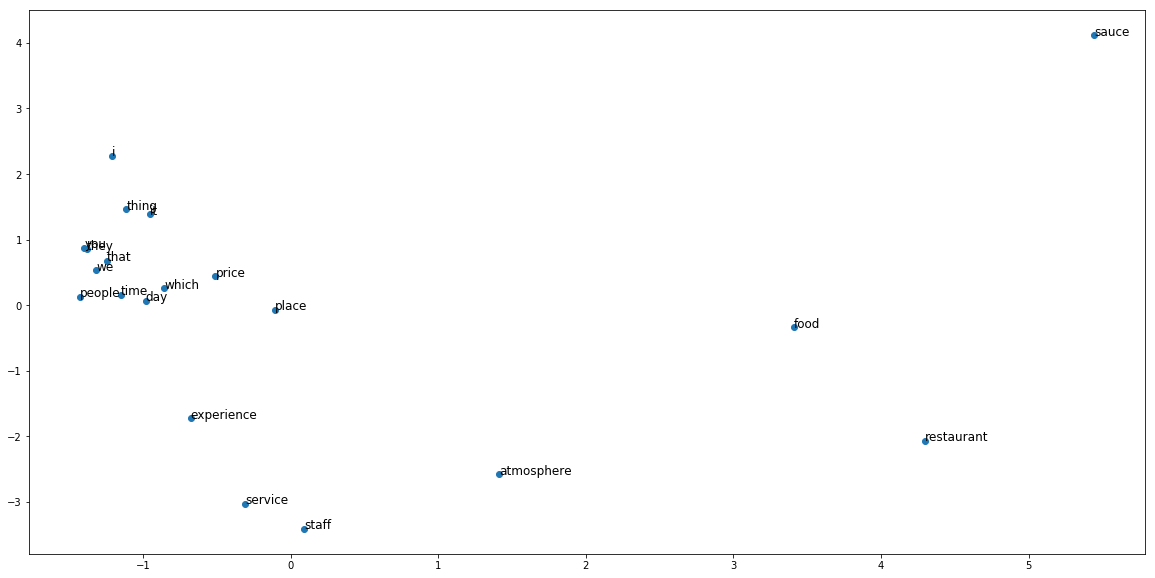

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.scatter(vectors_20_2D[:,0], vectors_20_2D[:,1])

for word, coord in zip(inv_nouns, vectors_20_2D):
    x, y = coord
    plt.text(x, y, word.text, size=12)

plt.show()

# Find relative nouns

In [11]:
def find_noun_object(nouns, text):
    for noun in nouns:
        if noun.text == text:
            return noun

# def find_relative_nouns(nouns, initial_nouns, threshold):
#     length_before = len(initial_nouns)
#     for noun in nouns:
#         for initial_noun in initial_nouns:
#             if noun.similarity(initial_noun) >= threshold:
#                 initial_nouns.add(noun)
#                 break
#     length_after = len(initial_nouns)
    
#     if length_before == length_after:
#         return initial_nouns
#     else:
#         return find_relative_nouns(nouns, initial_nouns, threshold)

def find_relative_nouns(nouns, initial_nouns, threshold):
    open_set = initial_nouns
    closed_set = set()

    while open_set:
        candidate = open_set.pop()
        for noun in nouns:
            if candidate.similarity(noun) >= threshold and noun not in closed_set:
                open_set.add(noun)
        closed_set.add(candidate)
    
    return closed_set

def get_nouns_in_aspects(nouns, aspects, threshold):
    aspects_dict = {}
    for aspect in aspects:
        obj = find_noun_object(nouns, aspect)
        initial_nouns = {obj}
        final_nouns = find_relative_nouns(nouns, initial_nouns, threshold)
        aspects_dict[aspect] = {noun.text for noun in final_nouns}
    return aspects_dict

In [12]:
aspects = {'price', 'atmosphere', 'food', 'service'}
threshold = 0.7

%time res = get_nouns_in_aspects(inv_nouns, aspects, threshold)

CPU times: user 1.43 s, sys: 133 ms, total: 1.56 s
Wall time: 1.45 s


In [13]:
from pprint import pprint
pprint(res)

{'atmosphere': {'ambiance',
                'ambience',
                'atmosphere',
                'decor',
                'decoration',
                'décor'},
 'food': {'breakfast',
          'brunch',
          'buffet',
          'dinner',
          'eat',
          'food',
          'lunch',
          'meal',
          'snack'},
 'price': {'price', 'cost', 'pricing'},
 'service': {'service'}}
